<a href="https://colab.research.google.com/github/abhishek-3740/machine_learningRepo/blob/main/Material_Classification_Using_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.0 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from PIL import ImageFile
import optuna
import os
import zipfile


In [3]:
# Setup
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download dataset
print("Setting up Kaggle API...")
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

print("Downloading dataset...")
!kaggle datasets download -d aashidutt3/waste-segregation-image-dataset

# Extract dataset
with zipfile.ZipFile('/content/waste-segregation-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
print("Dataset ready!")


Using device: cuda
Setting up Kaggle API...
Dataset URL: https://www.kaggle.com/datasets/aashidutt3/waste-segregation-image-dataset
License(s): CC-BY-NC-SA-4.0
 99% 1.16G/1.17G [00:05<00:00, 248MB/s]
100% 1.17G/1.17G [00:05<00:00, 239MB/s]
Dataset ready!


In [4]:
class ImprovedCNN(nn.Module):
    def __init__(self, filters1=16, filters2=32, fc1_size=128, fc2_size=64, dropout=0.5):
        super().__init__()

        # Feature layers (based on your original)
        self.features = nn.Sequential(
            nn.Conv2d(3, filters1, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(filters1, filters2, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Calculate size after convolutions (similar to your calculation)
        self.fc_input_size = filters2 * 63 * 63

        # Classifier (based on your original)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_size, fc1_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc1_size, fc2_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc2_size, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
def get_data_loaders(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.ImageFolder('/content/Dataset/train', transform=transform)

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, dataset.classes

In [6]:
import copy
# Training function
def train_model(model, train_loader, val_loader, config):
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

    best_acc = 0
    patience = 3
    no_improve = 0

    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                _, predicted = torch.max(outputs, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            no_improve = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "best_model.pth")  # Save best so far
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    model.load_state_dict(best_model_wts)
    return best_acc

In [7]:
def objective(trial):
    # Hyperparameters to optimize
    config = {
        'filters1': trial.suggest_categorical('filters1', [8, 16, 32]),
        'filters2': trial.suggest_categorical('filters2', [16, 32, 64]),
        'fc1_size': trial.suggest_categorical('fc1_size', [64, 128, 256]),
        'fc2_size': trial.suggest_categorical('fc2_size', [32, 64, 128]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.7),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw', 'sgd']),
        'epochs': 15  # Keep short for optimization
    }

    # Get data
    train_loader, val_loader, classes = get_data_loaders(config['batch_size'])

    # Create model
    model = ImprovedCNN(
        filters1=config['filters1'],
        filters2=config['filters2'],
        fc1_size=config['fc1_size'],
        fc2_size=config['fc2_size'],
        dropout=config['dropout']
    ).to(device)

    # Train and return best accuracy
    best_acc = train_model(model, train_loader, val_loader, config)
    return best_acc


In [8]:
print("Starting hyperparameter optimization...")
study = optuna.create_study(direction='maximize',study_name = 'cnn_tunning',storage = 'sqlite:///cnn_otuna.db',load_if_exists = True)
study.optimize(objective, n_trials=3)

print("Best trial:")
print(f"Accuracy: {study.best_trial.value:.2f}%")
print("Best params:", study.best_trial.params)

Starting hyperparameter optimization...


[I 2025-08-18 18:14:23,059] A new study created in RDB with name: cnn_tunning
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss: 0.2584, Val Acc: 93.08%
Epoch 2: Train Loss: 0.1907, Val Acc: 93.05%
Epoch 3: Train Loss: 0.1720, Val Acc: 93.68%
Epoch 4: Train Loss: 0.1602, Val Acc: 93.58%
Epoch 5: Train Loss: 0.1434, Val Acc: 93.36%
Epoch 6: Train Loss: 0.1437, Val Acc: 94.35%
Epoch 7: Train Loss: 0.1256, Val Acc: 94.88%
Epoch 8: Train Loss: 0.1215, Val Acc: 94.71%
Epoch 9: Train Loss: 0.1071, Val Acc: 94.85%


[I 2025-08-18 18:35:50,384] Trial 0 finished with value: 94.88175079421109 and parameters: {'filters1': 16, 'filters2': 64, 'fc1_size': 64, 'fc2_size': 32, 'dropout': 0.5340800267434618, 'lr': 0.0002058593254946692, 'batch_size': 16, 'optimizer': 'adam'}. Best is trial 0 with value: 94.88175079421109.


Epoch 10: Train Loss: 0.0975, Val Acc: 94.14%
Early stopping at epoch 10
Epoch 1: Train Loss: 0.2934, Val Acc: 90.72%
Epoch 2: Train Loss: 0.2171, Val Acc: 92.41%
Epoch 3: Train Loss: 0.2014, Val Acc: 92.69%
Epoch 4: Train Loss: 0.1899, Val Acc: 92.91%
Epoch 5: Train Loss: 0.1869, Val Acc: 92.98%
Epoch 6: Train Loss: 0.1804, Val Acc: 93.15%
Epoch 7: Train Loss: 0.1755, Val Acc: 93.15%
Epoch 8: Train Loss: 0.1697, Val Acc: 93.82%
Epoch 9: Train Loss: 0.1682, Val Acc: 93.86%
Epoch 10: Train Loss: 0.1609, Val Acc: 93.93%
Epoch 11: Train Loss: 0.1554, Val Acc: 94.28%
Epoch 12: Train Loss: 0.1556, Val Acc: 94.42%
Epoch 13: Train Loss: 0.1480, Val Acc: 94.46%
Epoch 14: Train Loss: 0.1444, Val Acc: 94.56%


[I 2025-08-18 19:09:23,889] Trial 1 finished with value: 94.56406636074833 and parameters: {'filters1': 32, 'filters2': 64, 'fc1_size': 256, 'fc2_size': 32, 'dropout': 0.493207650761415, 'lr': 0.00015245701083772475, 'batch_size': 16, 'optimizer': 'sgd'}. Best is trial 0 with value: 94.88175079421109.


Epoch 15: Train Loss: 0.1414, Val Acc: 94.25%
Epoch 1: Train Loss: 0.2424, Val Acc: 91.32%
Epoch 2: Train Loss: 0.2169, Val Acc: 91.10%
Epoch 3: Train Loss: 0.1981, Val Acc: 91.18%
Epoch 4: Train Loss: 0.1826, Val Acc: 91.46%
Epoch 5: Train Loss: 0.1679, Val Acc: 92.73%
Epoch 6: Train Loss: 0.1670, Val Acc: 91.78%
Epoch 7: Train Loss: 0.1473, Val Acc: 92.98%
Epoch 8: Train Loss: 0.1405, Val Acc: 92.66%
Epoch 9: Train Loss: 0.1252, Val Acc: 92.87%


[I 2025-08-18 19:31:11,023] Trial 2 finished with value: 92.97564419343452 and parameters: {'filters1': 32, 'filters2': 64, 'fc1_size': 64, 'fc2_size': 32, 'dropout': 0.46366845846682553, 'lr': 0.001833605455165152, 'batch_size': 16, 'optimizer': 'adamw'}. Best is trial 0 with value: 94.88175079421109.


Epoch 10: Train Loss: 0.1001, Val Acc: 92.87%
Early stopping at epoch 10
Best trial:
Accuracy: 94.88%
Best params: {'filters1': 16, 'filters2': 64, 'fc1_size': 64, 'fc2_size': 32, 'dropout': 0.5340800267434618, 'lr': 0.0002058593254946692, 'batch_size': 16, 'optimizer': 'adam'}


In [9]:
print("\nTraining final model with best parameters...")
best_params = study.best_trial.params
best_params['epochs'] = 30  # More epochs for final training

train_loader, val_loader, classes = get_data_loaders(best_params['batch_size'])

final_model = ImprovedCNN(
    filters1=best_params['filters1'],

    filters2=best_params['filters2'],
    fc1_size=best_params['fc1_size'],
    fc2_size=best_params['fc2_size'],
    dropout=best_params['dropout']
).to(device)

final_accuracy = train_model(final_model, train_loader, val_loader, best_params)

print(f"\nFinal Model Accuracy: {final_accuracy:.2f}%")
print(f"Your original accuracy: 96.7%")
print(f"Improvement: {final_accuracy - 96.7:.2f}%")

# Save the best model
torch.save(final_model.state_dict(), 'best_hypertuned_model.pth')
print("Model saved as 'best_hypertuned_model.pth'")



Training final model with best parameters...
Epoch 1: Train Loss: 0.2713, Val Acc: 93.33%
Epoch 2: Train Loss: 0.1876, Val Acc: 93.15%
Epoch 3: Train Loss: 0.1721, Val Acc: 93.61%
Epoch 4: Train Loss: 0.1558, Val Acc: 94.00%
Epoch 5: Train Loss: 0.1339, Val Acc: 94.67%
Epoch 6: Train Loss: 0.1209, Val Acc: 94.63%
Epoch 7: Train Loss: 0.1080, Val Acc: 94.81%
Epoch 8: Train Loss: 0.0917, Val Acc: 94.95%
Epoch 9: Train Loss: 0.0892, Val Acc: 95.16%
Epoch 10: Train Loss: 0.0780, Val Acc: 95.09%
Epoch 11: Train Loss: 0.0706, Val Acc: 95.06%
Epoch 12: Train Loss: 0.0644, Val Acc: 94.85%
Early stopping at epoch 12

Final Model Accuracy: 95.16%
Your original accuracy: 96.7%
Improvement: -1.54%
Model saved as 'best_hypertuned_model.pth'


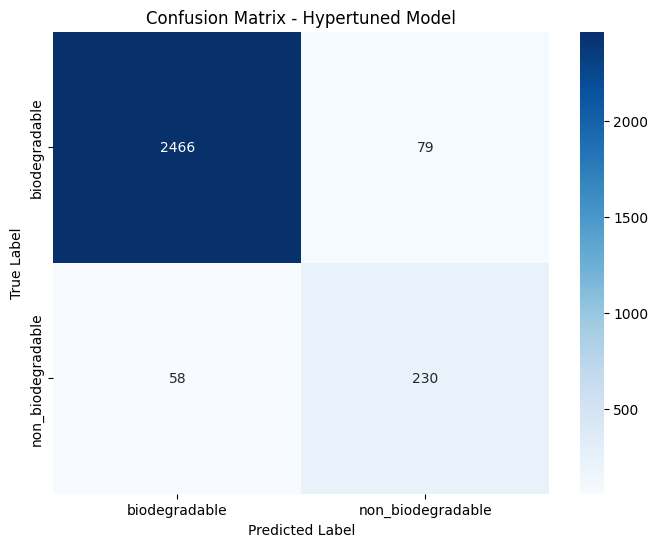


Classification Report:
                   precision    recall  f1-score   support

    biodegradable       0.98      0.97      0.97      2545
non_biodegradable       0.74      0.80      0.77       288

         accuracy                           0.95      2833
        macro avg       0.86      0.88      0.87      2833
     weighted avg       0.95      0.95      0.95      2833



In [10]:
final_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = final_model(batch_features)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Show confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Hypertuned Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

# ==== 1. Load trained model with CORRECT parameters ====
# Use the best parameters from your hyperparameter optimization
best_params = {
    'filters1': 16,
    'filters2': 64,  # This was 64 in your saved model, not 16!
    'fc1_size': 64,  # This was 64 in your saved model, not 128!
    'fc2_size': 32,
    'dropout': 0.5340800267434618
}

model = ImprovedCNN(
    filters1=best_params['filters1'],
    filters2=best_params['filters2'],  # 64, not 16
    fc1_size=best_params['fc1_size'],  # 64, not 128
    fc2_size=best_params['fc2_size'],
    dropout=best_params['dropout']
).to(device)

# Now load the saved weights - they should match perfectly
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# ==== 2. Preprocessing ====
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

classes = ["Biodegradable", "Non-Biodegradable"]


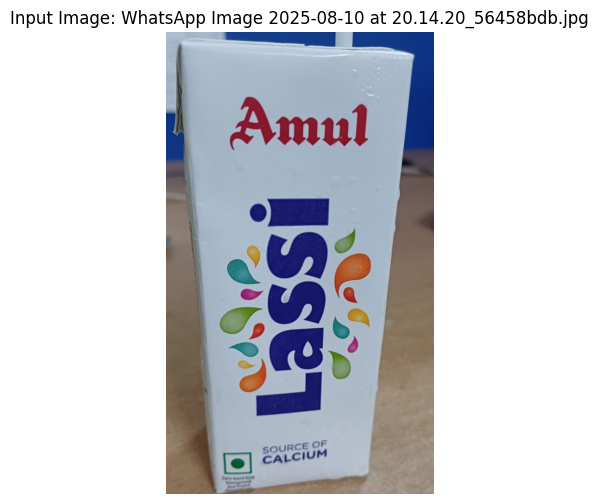

First model prediction: Non-Biodegradable
First model confidence: 0.6756 (67.56%)

Using the newer hypertuned model:


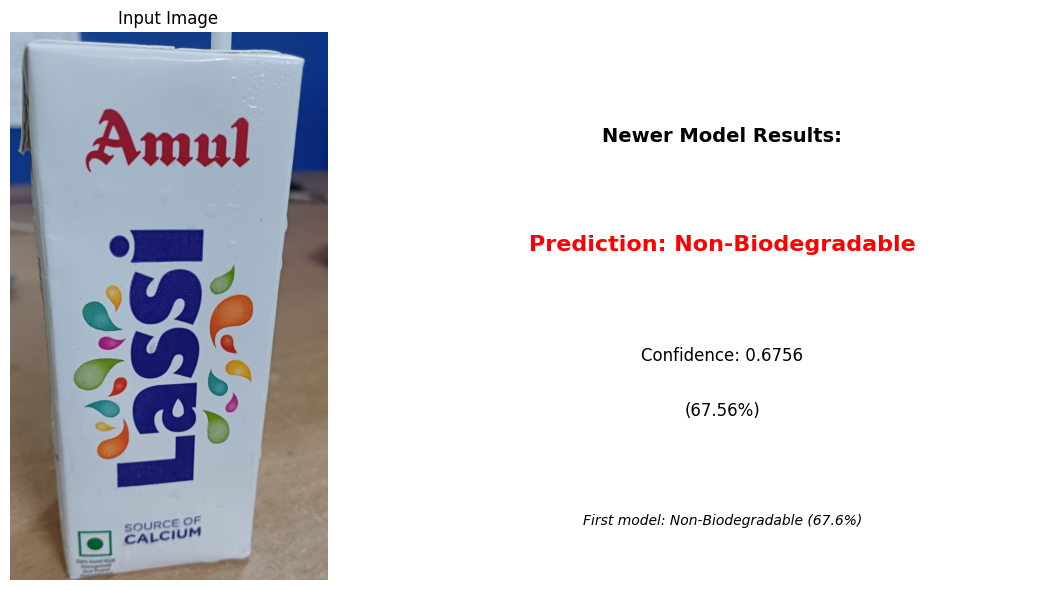

Newer model prediction: Non-Biodegradable
Newer model confidence: 0.6756 (67.56%)

============================== SUMMARY ==============================
Image: WhatsApp Image 2025-08-10 at 20.14.20_56458bdb.jpg
First Model:  Non-Biodegradable (67.56%)
Newer Model:  Non-Biodegradable (67.56%)
✅ Both models agree!


In [15]:

# ==== 3. Load and display the image ====
image_path = "/content/WhatsApp Image 2025-08-10 at 20.14.20_56458bdb.jpg"

# Display the image
img = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f"Input Image: {image_path.split('/')[-1]}")
plt.axis('off')
plt.show()

# ==== 4. Make prediction with first model ====
img_rgb = Image.open(image_path).convert("RGB")
input_tensor = transform(img_rgb).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probabilities, 1)
    label = classes[predicted.item()]

print(f"First model prediction: {label}")
print(f"First model confidence: {confidence.item():.4f} ({confidence.item()*100:.2f}%)")

print("\n" + "="*50)
print("Using the newer hypertuned model:")

# ==== 5. Load the newer hypertuned model ====
newer_model = ImprovedCNN(
    filters1=best_params['filters1'],
    filters2=best_params['filters2'],
    fc1_size=best_params['fc1_size'],
    fc2_size=best_params['fc2_size'],
    dropout=best_params['dropout']
).to(device)

# Load the newer saved model
newer_model.load_state_dict(torch.load("best_hypertuned_model.pth", map_location=device))
newer_model.eval()

# ==== 6. Make prediction with newer model ====
with torch.no_grad():
    outputs_new = newer_model(input_tensor)
    probabilities_new = torch.softmax(outputs_new, dim=1)
    confidence_new, predicted_new = torch.max(probabilities_new, 1)
    label_new = classes[predicted_new.item()]

# ==== 7. Display image with prediction results ====
plt.figure(figsize=(12, 6))

# Show image on left
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

# Show prediction results on right
plt.subplot(1, 2, 2)
plt.text(0.5, 0.8, f"Newer Model Results:", fontsize=14, ha='center', transform=plt.gca().transAxes, weight='bold')
plt.text(0.5, 0.6, f"Prediction: {label_new}", fontsize=16, ha='center', transform=plt.gca().transAxes,
         color='green' if label_new == 'Biodegradable' else 'red', weight='bold')
plt.text(0.5, 0.4, f"Confidence: {confidence_new.item():.4f}", fontsize=12, ha='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.3, f"({confidence_new.item()*100:.2f}%)", fontsize=12, ha='center', transform=plt.gca().transAxes)

# Add comparison with first model
plt.text(0.5, 0.1, f"First model: {label} ({confidence.item()*100:.1f}%)",
         fontsize=10, ha='center', transform=plt.gca().transAxes, style='italic')

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Newer model prediction: {label_new}")
print(f"Newer model confidence: {confidence_new.item():.4f} ({confidence_new.item()*100:.2f}%)")

# ==== 8. Show both predictions summary ====
print("\n" + "="*30 + " SUMMARY " + "="*30)
print(f"Image: {image_path.split('/')[-1]}")
print(f"First Model:  {label} ({confidence.item()*100:.2f}%)")
print(f"Newer Model:  {label_new} ({confidence_new.item()*100:.2f}%)")

if label == label_new:
    print("✅ Both models agree!")
else:
    print("⚠️  Models disagree - check your data!")

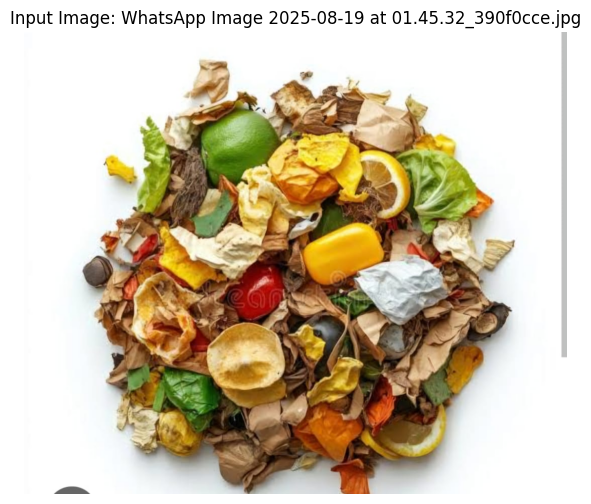

First model prediction: Biodegradable
First model confidence: 0.9999 (99.99%)

Using the newer hypertuned model:


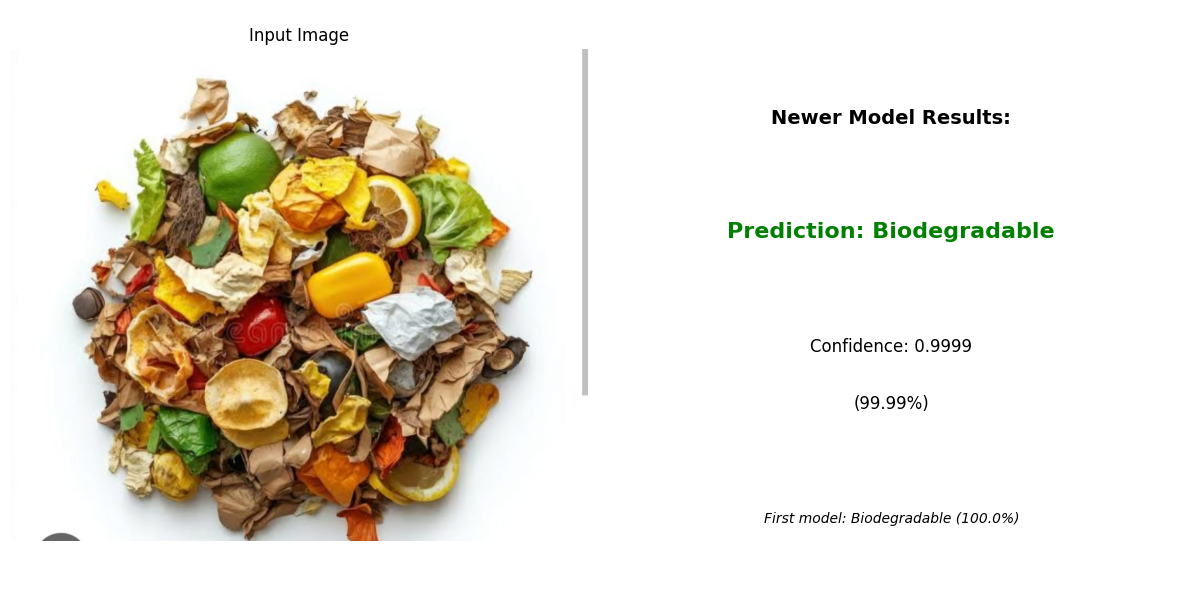

Newer model prediction: Biodegradable
Newer model confidence: 0.9999 (99.99%)

============================== SUMMARY ==============================
Image: WhatsApp Image 2025-08-19 at 01.45.32_390f0cce.jpg
First Model:  Biodegradable (99.99%)
Newer Model:  Biodegradable (99.99%)
✅ Both models agree!


In [18]:

# ==== 3. Load and display the image ====
image_path = "/content/WhatsApp Image 2025-08-19 at 01.45.32_390f0cce.jpg"

# Display the image
img = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f"Input Image: {image_path.split('/')[-1]}")
plt.axis('off')
plt.show()

# ==== 4. Make prediction with first model ====
img_rgb = Image.open(image_path).convert("RGB")
input_tensor = transform(img_rgb).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probabilities, 1)
    label = classes[predicted.item()]

print(f"First model prediction: {label}")
print(f"First model confidence: {confidence.item():.4f} ({confidence.item()*100:.2f}%)")

print("\n" + "="*50)
print("Using the newer hypertuned model:")

# ==== 5. Load the newer hypertuned model ====
newer_model = ImprovedCNN(
    filters1=best_params['filters1'],
    filters2=best_params['filters2'],
    fc1_size=best_params['fc1_size'],
    fc2_size=best_params['fc2_size'],
    dropout=best_params['dropout']
).to(device)

# Load the newer saved model
newer_model.load_state_dict(torch.load("best_hypertuned_model.pth", map_location=device))
newer_model.eval()

# ==== 6. Make prediction with newer model ====
with torch.no_grad():
    outputs_new = newer_model(input_tensor)
    probabilities_new = torch.softmax(outputs_new, dim=1)
    confidence_new, predicted_new = torch.max(probabilities_new, 1)
    label_new = classes[predicted_new.item()]

# ==== 7. Display image with prediction results ====
plt.figure(figsize=(12, 6))

# Show image on left
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

# Show prediction results on right
plt.subplot(1, 2, 2)
plt.text(0.5, 0.8, f"Newer Model Results:", fontsize=14, ha='center', transform=plt.gca().transAxes, weight='bold')
plt.text(0.5, 0.6, f"Prediction: {label_new}", fontsize=16, ha='center', transform=plt.gca().transAxes,
         color='green' if label_new == 'Biodegradable' else 'red', weight='bold')
plt.text(0.5, 0.4, f"Confidence: {confidence_new.item():.4f}", fontsize=12, ha='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.3, f"({confidence_new.item()*100:.2f}%)", fontsize=12, ha='center', transform=plt.gca().transAxes)

# Add comparison with first model
plt.text(0.5, 0.1, f"First model: {label} ({confidence.item()*100:.1f}%)",
         fontsize=10, ha='center', transform=plt.gca().transAxes, style='italic')

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Newer model prediction: {label_new}")
print(f"Newer model confidence: {confidence_new.item():.4f} ({confidence_new.item()*100:.2f}%)")

# ==== 8. Show both predictions summary ====
print("\n" + "="*30 + " SUMMARY " + "="*30)
print(f"Image: {image_path.split('/')[-1]}")
print(f"First Model:  {label} ({confidence.item()*100:.2f}%)")
print(f"Newer Model:  {label_new} ({confidence_new.item()*100:.2f}%)")

if label == label_new:
    print("✅ Both models agree!")
else:
    print("⚠️  Models disagree - check your data!")

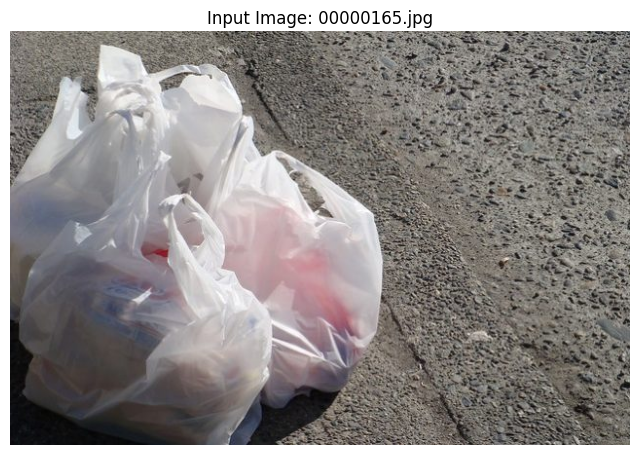

First model prediction: Non-Biodegradable
First model confidence: 0.6894 (68.94%)

Using the newer hypertuned model:


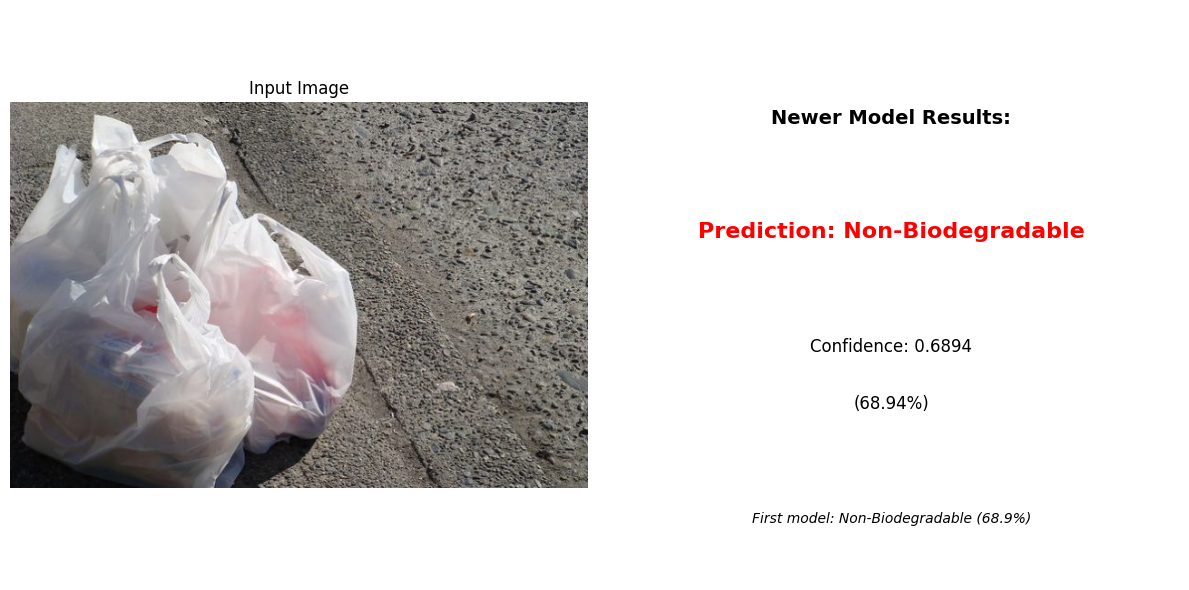

Newer model prediction: Non-Biodegradable
Newer model confidence: 0.6894 (68.94%)

============================== SUMMARY ==============================
Image: 00000165.jpg
First Model:  Non-Biodegradable (68.94%)
Newer Model:  Non-Biodegradable (68.94%)
✅ Both models agree!


In [26]:

# ==== 3. Load and display the image ====
image_path = "/content/Dataset/train/non_biodegradable/plastic_bags/00000165.jpg"

# Display the image
img = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f"Input Image: {image_path.split('/')[-1]}")
plt.axis('off')
plt.show()

# ==== 4. Make prediction with first model ====
img_rgb = Image.open(image_path).convert("RGB")
input_tensor = transform(img_rgb).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probabilities, 1)
    label = classes[predicted.item()]

print(f"First model prediction: {label}")
print(f"First model confidence: {confidence.item():.4f} ({confidence.item()*100:.2f}%)")

print("\n" + "="*50)
print("Using the newer hypertuned model:")

# ==== 5. Load the newer hypertuned model ====
newer_model = ImprovedCNN(
    filters1=best_params['filters1'],
    filters2=best_params['filters2'],
    fc1_size=best_params['fc1_size'],
    fc2_size=best_params['fc2_size'],
    dropout=best_params['dropout']
).to(device)

# Load the newer saved model
newer_model.load_state_dict(torch.load("best_hypertuned_model.pth", map_location=device))
newer_model.eval()

# ==== 6. Make prediction with newer model ====
with torch.no_grad():
    outputs_new = newer_model(input_tensor)
    probabilities_new = torch.softmax(outputs_new, dim=1)
    confidence_new, predicted_new = torch.max(probabilities_new, 1)
    label_new = classes[predicted_new.item()]

# ==== 7. Display image with prediction results ====
plt.figure(figsize=(12, 6))

# Show image on left
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

# Show prediction results on right
plt.subplot(1, 2, 2)
plt.text(0.5, 0.8, f"Newer Model Results:", fontsize=14, ha='center', transform=plt.gca().transAxes, weight='bold')
plt.text(0.5, 0.6, f"Prediction: {label_new}", fontsize=16, ha='center', transform=plt.gca().transAxes,
         color='green' if label_new == 'Biodegradable' else 'red', weight='bold')
plt.text(0.5, 0.4, f"Confidence: {confidence_new.item():.4f}", fontsize=12, ha='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.3, f"({confidence_new.item()*100:.2f}%)", fontsize=12, ha='center', transform=plt.gca().transAxes)

# Add comparison with first model
plt.text(0.5, 0.1, f"First model: {label} ({confidence.item()*100:.1f}%)",
         fontsize=10, ha='center', transform=plt.gca().transAxes, style='italic')

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Newer model prediction: {label_new}")
print(f"Newer model confidence: {confidence_new.item():.4f} ({confidence_new.item()*100:.2f}%)")

# ==== 8. Show both predictions summary ====
print("\n" + "="*30 + " SUMMARY " + "="*30)
print(f"Image: {image_path.split('/')[-1]}")
print(f"First Model:  {label} ({confidence.item()*100:.2f}%)")
print(f"Newer Model:  {label_new} ({confidence_new.item()*100:.2f}%)")

if label == label_new:
    print("✅ Both models agree!")
else:
    print("⚠️  Models disagree - check your data!")